# Lab II for M2 Health-AI | Machine Learning and Deep Learning course

# Medical Image Segmentation using UNET

Tewodros W. AREGA (tewdrosw@gmail.com), M2 Health-AI | Machine Learning and Deep Learning course


In this lab, we will focus on medical image segmentation using UNET network architecture.

For the dataset, we will use [ACDC challenge](https://www.creatis.insa-lyon.fr/Challenge/acdc/). It consists of  cine cardiac MRI image of 100 patients. The main task is to segment Left ventricle (blue) and Myocardium (green) of the heart.



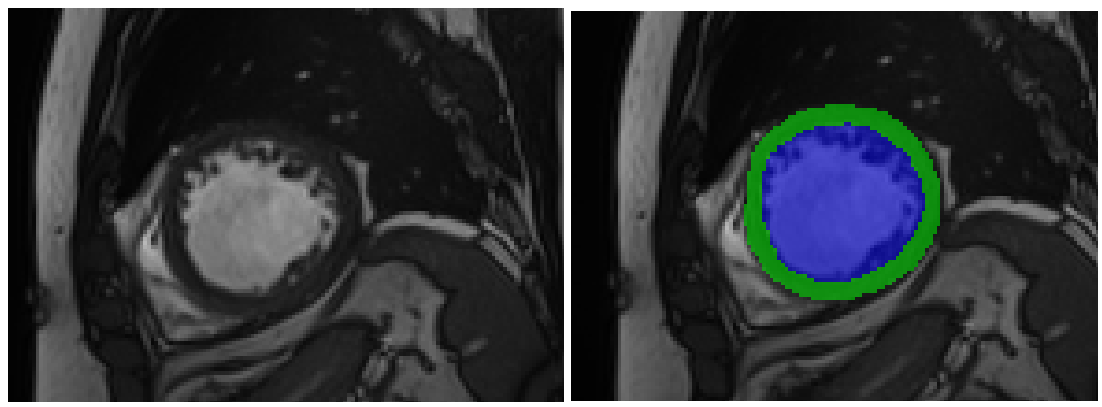

# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


# Import

In [ ]:
!pip install SimpleITK

#############
import os
import random
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
import time
import glob
import sys
import logging
import cv2


#############
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision

np.random.seed(123)
torch.manual_seed(123)

%load_ext autoreload
%autoreload 2

     |████████████████████████████████| 48.4 MB 2.3 MB/s 


In [ ]:
#Uncomment the next line if you want to unzip the ACDC dataset, it may take -- mins to unzip the folder
# !unzip -u "/content/drive/My Drive/CNN_COURSE/ACDC_2D.zip" -d "/content/drive/My Drive/CNN_COURSE/ACDC"

# Hyper-parameters

In [ ]:
###################################################################
# Hyperparameters
###################################################################
mytime = time.strftime("%Y_%m_%d_%HH_%MM")

options = {}
options['train_split']  = 0.2
options['val_split']  = 0.2

options["models"]='/content/drive/My Drive/CNN_COURSE/Model_Results/Models/'
options["results"]='/content/drive/My Drive/CNN_COURSE/Model_Results/Results/'

class_weights = [1.0, 1.0, 1.0]  #weight for each class if you want to use weighted loss function
options["loss_type"] = "diceloss"   # "diceloss", "crossentropy"
options["metrics"] = "dicecoeff"

EPOCH_NO = 50
earlystopping = 10 # the patience for early stopping

BATCHSIZE = 16
options['batch_size'] = BATCHSIZE

options["optim"] = "adam"

lrate = 1e-4    # learning rate for the optimizer
weightdecay = 0.0000000

MODEL_TYPE = "UNet"

data_name = "ACDC"
exp_name = MODEL_TYPE+'_'+ data_name +'_batchsize_'+str(BATCHSIZE)+'_loss_'+options["loss_type"]+'_optim_'+options["optim"]+'_epoch_'+str(EPOCH_NO)+ '_t'+ mytime

model_name = exp_name

In [ ]:
exp_name

'UNet_ACDC_batchsize_16_loss_diceloss_optim_adam_epoch_50_t2022_01_25_18H_35M'

# Data Preparation

Compared to the first lab, to handle the dataset we will use Pytorch's `Dataset` and `Dataloader`.

Similar to other *Deep Learning* toolkits, Pytorch incorporates some objects to deal with data efficiently. In particular, we will make use of `Datasets` and `Dataloaders`:

* `Datasets` objects are used to build customs datasets from our data, permitting us to manage training data very efficiently. For instance, imagine a custom dataset with hundreds of MRI subjects containing several input modalities. Loading and managing this amount of information may be tricky in some situations, so a custom `Dataset` that loads the data when necessary is convenient.


* `Dataloaders` take `Datasets` as input and permits to automatically collate individual fetched data samples into batches via arguments. `Dataloaders` yield consecutive batch samples during the training loop, handling all the data requirements via the `Dataset` object.  

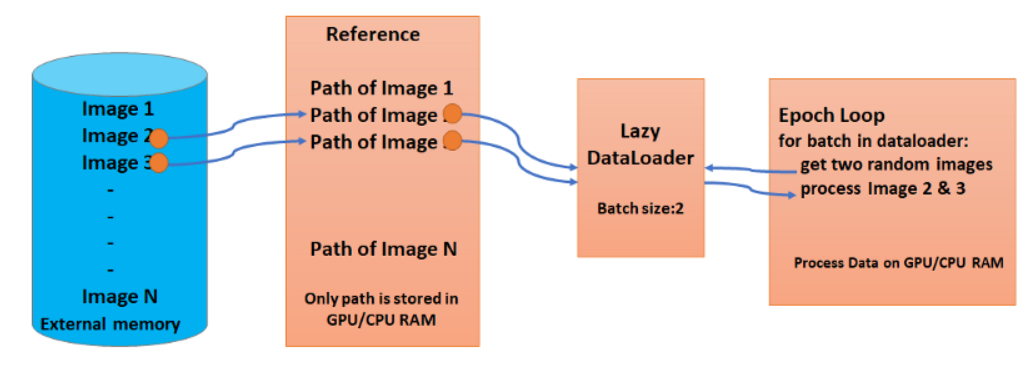

## Dataset

`Dataset` stores the samples and their corresponding labels


In [ ]:

class Mydataset(data.Dataset):

  '''
  Custom dataset
  '''

  def __init__(self, imgs, masks, transform=None, normalize=True):
    '''
    The __init__ function is run once when instantiating the Dataset object.
    '''

    # list of image and label file names
    self.imgs = imgs
    self.masks = masks
    self.transform = transform
    self.normalize = normalize

  def __getitem__(self, idx):
    '''
    The __getitem__ function loads and returns a sample from the dataset at the given index idx. Based on the index, it identifies the image’s
     and label's location on disk, reads and converts that to a tensor. It also normalizes the images
    '''

    #load images ad masks
    img = np.load(self.imgs[idx])
    mask = np.load(self.masks[idx])


    img_nm = self.imgs[idx]
    mask_nm = self.masks[idx]

    #normalization,
    if self.normalize:
      img = normalize_data(img)

    return img, mask, img_nm

  def __len__(self):
    '''returns the number of samples in the dataset. '''
    return len(self.imgs)


def normalize_data(im,
                   norm_type='standard',
                   datatype=np.float32):
    """
    Zero mean normalization

    inputs:
    - im: input data
    - norm_type: 'zero_one', 'standard'

    outputs:
    - normalized image
    """

    if norm_type == 'standard':
        im = im.astype(dtype=datatype) - im.mean()
        im = im / im.std()

    if norm_type == 'zero_one':
        min_int = abs(im.min())
        max_int = im.max()
        if im.min() < 0:
            im = im.astype(dtype=datatype) + min_int
            im = im / (max_int + min_int)
        else:
            im = (im.astype(dtype=datatype) - min_int) / max_int

    return im


Retrieving the image list from drive

We then split the available data into training, validation and test sets.

In [ ]:
if data_name == "ACDC":
  resample_dir = '/content/drive/MyDrive/ACDC_2D/'
  my_extension = "*_resampled.npy"
  my_mask_extension = "*_resampled_seg.npy"
  image_npy = "ALL_IMAGES_NPY/"
  mask_npy = "ALL_MASKS_NPY/"

img_files = list(sorted( glob.glob(resample_dir +image_npy+ my_extension)  ))
mask_files = list(sorted( glob.glob(resample_dir +mask_npy+ my_mask_extension) ))

#spliting the dataset into training, validation and test set (60:20:20)
t_train = int(len(img_files) * (1 - (options['train_split'] + options['val_split']) ))
t_val = int(len(img_files) * (1 - options['val_split']))
training_data = img_files[:t_train]
training_mask = mask_files[:t_train]
validation_data = img_files[t_train:t_val]
validation_mask = mask_files[t_train:t_val]
test_data = img_files[t_val:]
test_mask = mask_files[t_val:]




Build the `Datasets` for training, validation and testing data. Also  we [normalize](https://datascience.stackexchange.com/questions/32109/zero-mean-and-unit-variance) images with `mean=0` and `std=1`.

In [ ]:
# Instantaite the custom dataset class
training_dataset = Mydataset(training_data, training_mask, normalize=True)
validation_dataset = Mydataset(validation_data, validation_mask, normalize=True)
test_dataset = Mydataset(test_data, test_mask, normalize=True)

print("Number of training images:"+str(len(training_data)))
print("Number of validation images:"+str(len(validation_data)))
print("Number of test images:"+str(len(test_data)))


Number of training images:1096
Number of validation images:366
Number of test images:366


In [ ]:
#List the training images file names
print(training_data)
print(training_mask)

['/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_1_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_2_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_3_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_4_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_5_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_6_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_7_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_8_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_DS_SLICE_9_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_SS_SLICE_1_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_SS_SLICE_2_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient001_SS_SLI

In [ ]:
#List the validation images file names
print(validation_data)
print(validation_mask)

['/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_0_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_1_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_2_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_3_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_4_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_5_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_6_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_7_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_8_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_DS_SLICE_9_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_SS_SLICE_0_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient062_SS_SLI

In [ ]:
#List the test images file names
print(test_data)
print(test_mask)

['/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient082_SS_SLICE_4_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient082_SS_SLICE_5_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient082_SS_SLICE_6_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient082_SS_SLICE_7_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient082_SS_SLICE_8_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient082_SS_SLICE_9_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient083_DS_SLICE_0_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient083_DS_SLICE_1_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient083_DS_SLICE_2_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient083_DS_SLICE_3_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient083_DS_SLICE_4_resampled.npy', '/content/drive/MyDrive/ACDC_2D/ALL_IMAGES_NPY/patient083_DS_SLI

## DataLoader

`DataLoader` wraps an iterable around the `Dataset` to enable easy access to the samples.

While training a model, we typically want to pass samples in “minibatches”, reshuffle the data at every epoch to reduce model overfitting, and use Python’s multiprocessing to speed up data retrieval. DataLoader is an iterable that abstracts this complexity for us in an easy API.

In [ ]:
# Python iterable over a dataset
training_dataloader = DataLoader(training_dataset,
                                 batch_size=options['batch_size'],
                                 shuffle=True)
validation_dataloader = DataLoader(validation_dataset,
                                 batch_size=options['batch_size'],
                                 shuffle=True)
test_dataloader = DataLoader(test_dataset,
                                 batch_size=options['batch_size'],
                                 shuffle=False)

## Visualize the Images


torch.Size([16, 1, 144, 144])
torch.Size([16, 1, 144, 144])


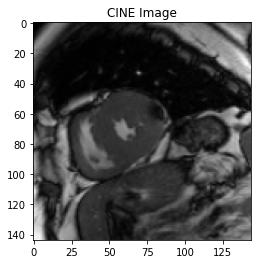

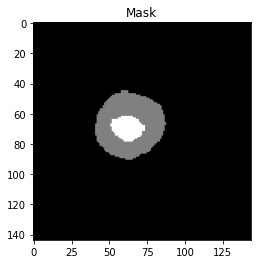

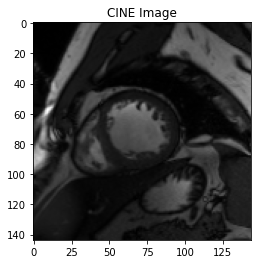

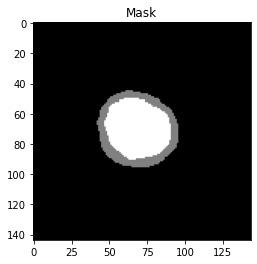

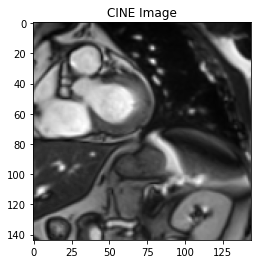

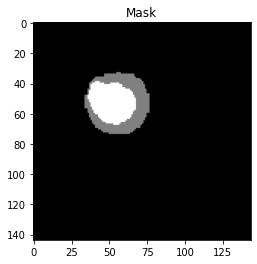

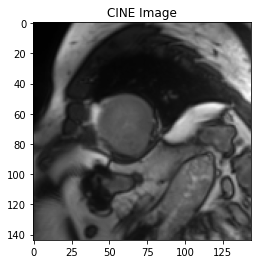

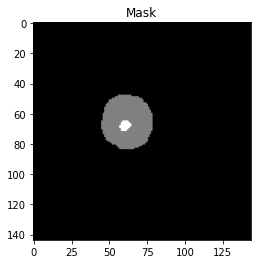

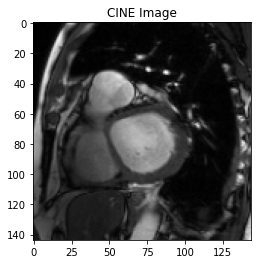

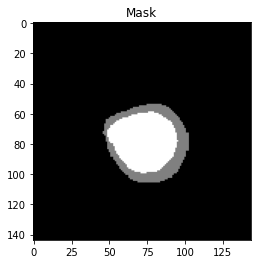

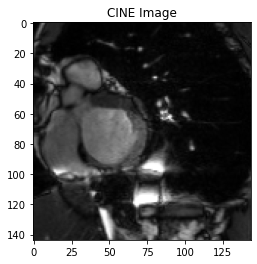

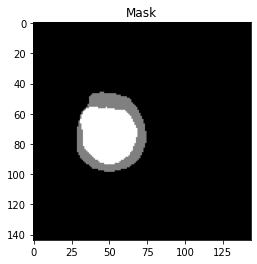

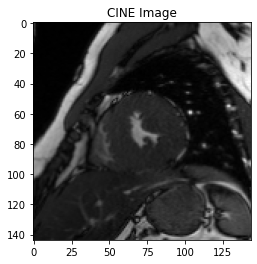

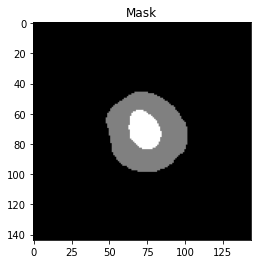

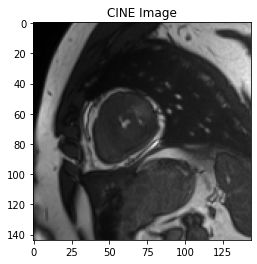

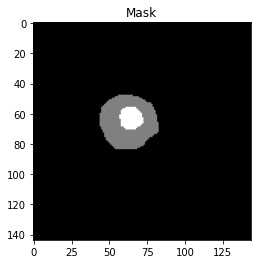

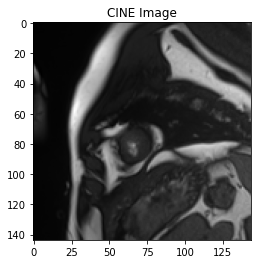

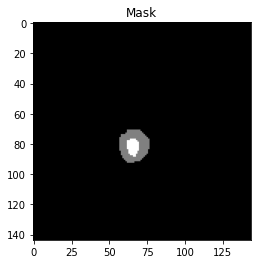

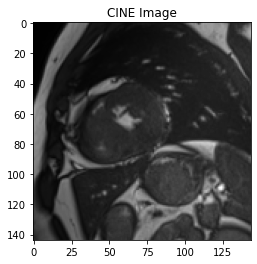

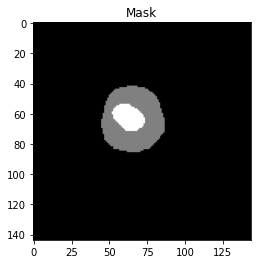

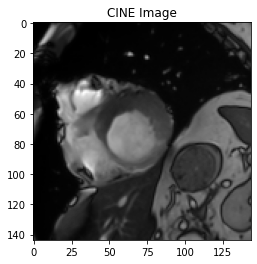

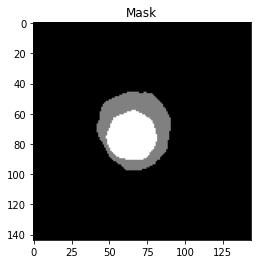

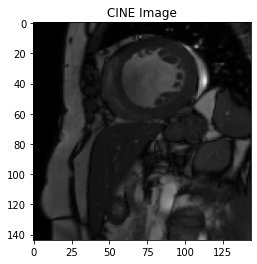

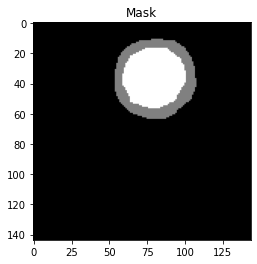

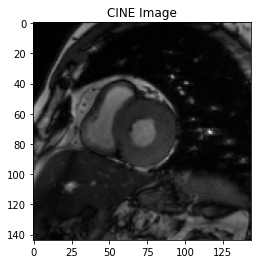

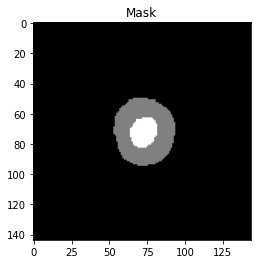

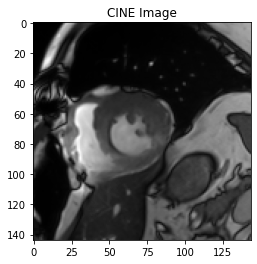

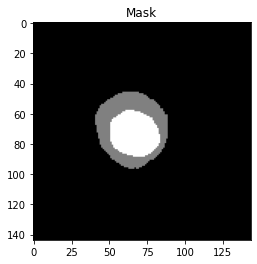

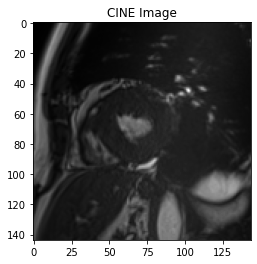

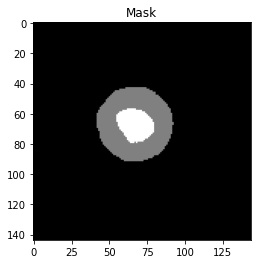

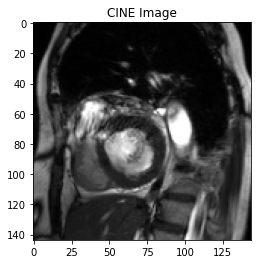

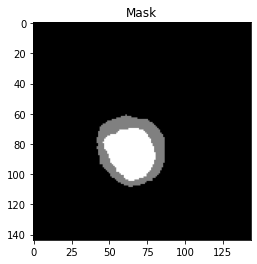

In [ ]:
# Each iteration below returns a batch (16) of training images  and labels
images,labels, _ = next(iter(training_dataloader))
print(labels.shape)
print(images.shape)

for j in range(options['batch_size']):
  plt.imshow(images[j,0,:,:], cmap='gray')
  plt.title("CINE Image")
  plt.show()

  plt.imshow(labels[j,0,:,:], cmap='gray')
  plt.title("Mask")
  plt.show()

# Network Architecture

# The U-NET model:
---

The encoder-decoder U-NET model was proposed by [Ronneberger et al. 2015](https://lmb.informatik.uni-freiburg.de/Publications/2015/RFB15a/) in the context of biomedical image segmentation (microscopy imaging). Encoder-decoder models are very similar to [autoencoders](https://en.wikipedia.org/wiki/Autoencoder), so the encoding part compresses the input image into the latent space, meaning that we end up with a very efficient compressed version of the image with a lot less information.

Based on the latent space, the decoder part reconstructs the image back. Compared to other encoder-decoder architectures like the [SegNET](https://mi.eng.cam.ac.uk/projects/segnet/), the U-NET model introduced the copy and crop elements, so activations for each of the encoder layers were concatenated (or added) to the same level decoding layers in order to help to reconstruct the image structure prior to segmentation.

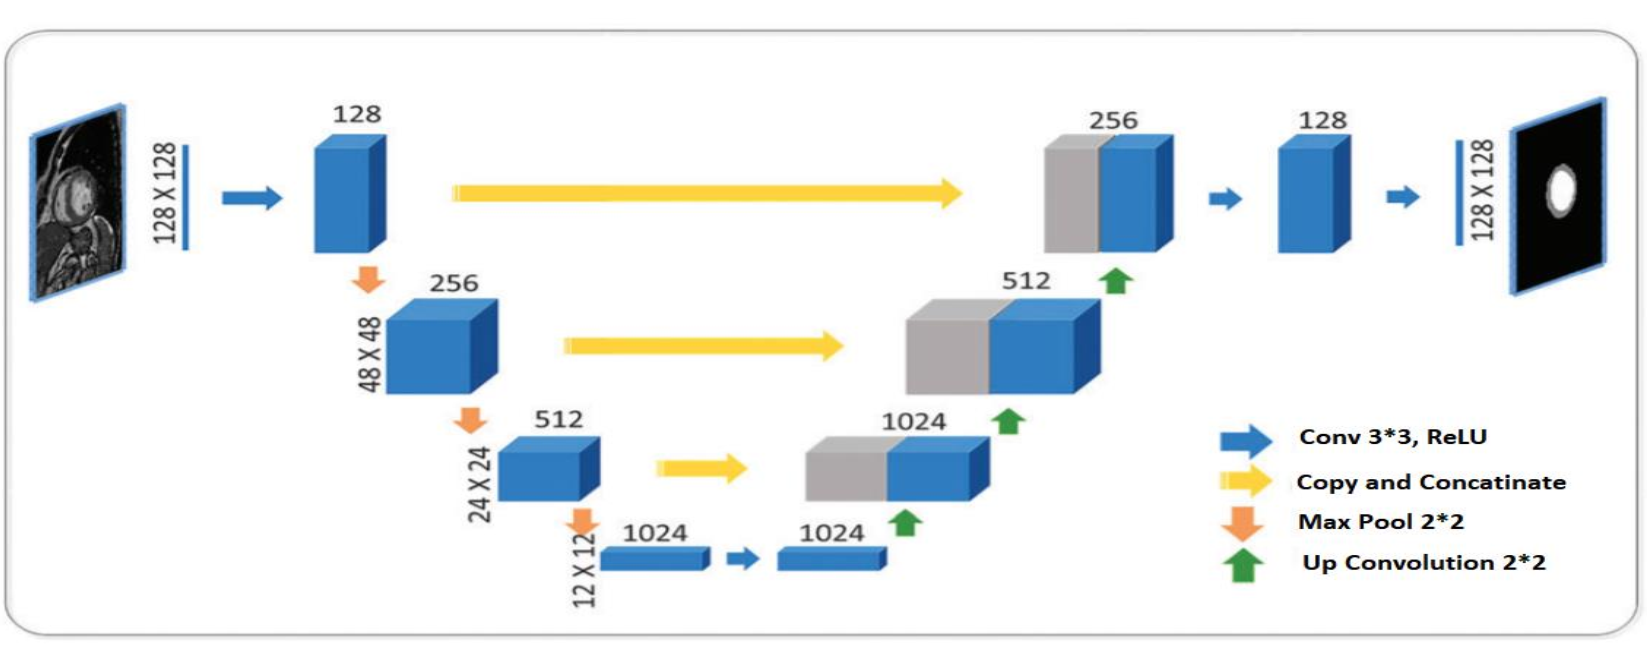

## Simplified UNET

Notice that in this UNET, we added the features maps that goes from the encoder to the decoder instead of concatenation.

In [ ]:
#UNET Architecture

class UNet(nn.Module):
    """
    Basic U-net model
    """

    def __init__(self, in_channels=1, out_channels=3):

        super(UNet, self).__init__()
        # Here We define the building blocks of the network and
        # they are stored in the object(.self) for later use

        # conv1 down
        self.conv1 = nn.Conv2d(in_channels=in_channels,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # pool 1
        # self.pool1 = nn.Conv2d(in_channels=32,
        #                        out_channels=32,
        #                        kernel_size=2,
        #                        stride=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv2 down
        self.conv2 = nn.Conv2d(in_channels=32,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # pool 2
        # self.pool2 = nn.Conv2d(in_channels=64,
        #                        out_channels=64,
        #                        kernel_size=2,
        #                        stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv3 down
        self.conv3 = nn.Conv2d(in_channels=64,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # pool 3
        # self.pool3 = nn.Conv2d(in_channels=128,
        #                        out_channels=128,
        #                        kernel_size=2,
        #                        stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # conv4 down (latent space)
        self.conv4 = nn.Conv2d(in_channels=128,
                               out_channels=256,
                               kernel_size=3,
                               padding=1)
        # up-sample conv4
        self.up1 = nn.ConvTranspose2d(in_channels=256,
                                      out_channels=128,
                                      kernel_size=2,
                                      stride=2)
        # conv 5 (add up1 + conv3)
        self.conv5 = nn.Conv2d(in_channels=128,
                               out_channels=128,
                               kernel_size=3,
                               padding=1)
        # up-sample conv5
        self.up2 = nn.ConvTranspose2d(in_channels=128,
                                      out_channels=64,
                                      kernel_size=2,
                                      stride=2)
        # conv6 (add up2 + conv2)
        self.conv6 = nn.Conv2d(in_channels=64,
                               out_channels=64,
                               kernel_size=3,
                               padding=1)
        # up 3
        self.up3 = nn.ConvTranspose2d(in_channels=64,
                                      out_channels=32,
                                      kernel_size=2,
                                      stride=2)
        # conv7 (add up3 + conv1)
        self.conv7 = nn.Conv2d(in_channels=32,
                               out_channels=32,
                               kernel_size=3,
                               padding=1)
        # conv8 (classification)
        self.conv8 = nn.Conv2d(in_channels=32,
                               out_channels=out_channels,
                               kernel_size=1)

    def forward(self, x):

        # Here the forward propagation is specified
        # input-output data flow

        # encoder
        x1 = F.relu(self.conv1(x))
        x1p = self.pool1(x1)
        x2 = F.relu(self.conv2(x1p))
        x2p = self.pool2(x2)
        x3 = F.relu(self.conv3(x2p))
        x3p = self.pool3(x3)

        # latent space
        x4 = F.relu(self.conv4(x3p))

        # decoder
        up1 = self.up1(x4)
        x5 = F.relu(self.conv5(up1 + x3)) # look how layers are added :o
        up2 = self.up2(x5)
        x6 = F.relu(self.conv6(up2 + x2))
        up3 = self.up3(x6)
        x7 = F.relu(self.conv7(up3 + x1))

        # output layer (3 classes)
        # we use a softmax layer to return probabilities for each class
        # Be careful if you are using crossentropy loss function
        out = F.softmax(self.conv8(x7), dim=1)
        return out


## Question

How many parameters does the network have?

Does the input image size affect the number parameters of the network?

Compare your result with the one computed by torchsummary in the cell below:

In [ ]:
from torchsummary import summary
options['gpu_use'] = True

my_unet = UNet(in_channels=1, out_channels=3)
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')
my_unet = my_unet.to(device)

summary(my_unet, (1, 288, 288))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 288, 288]             320
         MaxPool2d-2         [-1, 32, 144, 144]               0
            Conv2d-3         [-1, 64, 144, 144]          18,496
         MaxPool2d-4           [-1, 64, 72, 72]               0
            Conv2d-5          [-1, 128, 72, 72]          73,856
         MaxPool2d-6          [-1, 128, 36, 36]               0
            Conv2d-7          [-1, 256, 36, 36]         295,168
   ConvTranspose2d-8          [-1, 128, 72, 72]         131,200
            Conv2d-9          [-1, 128, 72, 72]         147,584
  ConvTranspose2d-10         [-1, 64, 144, 144]          32,832
           Conv2d-11         [-1, 64, 144, 144]          36,928
  ConvTranspose2d-12         [-1, 32, 288, 288]           8,224
           Conv2d-13         [-1, 32, 288, 288]           9,248
           Conv2d-14          [-1, 3, 2

# Utils

In [ ]:
def plotMetrics(training_loss, val_loss):

    # plot training and val loss
    plt.plot(training_loss)
    plt.plot(val_loss)
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


## Dice Coefficient

Dice coefficient measures the similarity of two images. It is calculated as the size of the overlap between segmented image and ground truth divided by the total size of the two images. This measures the overall quality of a segmentation. The Dice index gives a measurement value between 0 (no overlap) and 1 (full overlap).



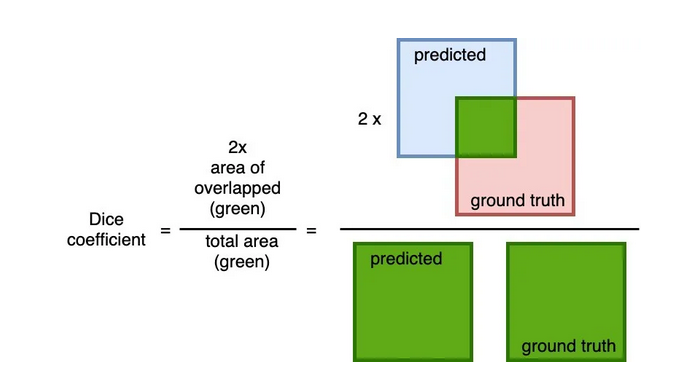

## Loss Functions and Metrics

In [ ]:
def dice_coef_metric(pred, target):
  """This definition generalize to real valued pred and target vector.
      This should be differentiable.
      pred: tensor with first dimension as batch
      target: tensor with first dimension as batch
  """
  smooth = 1.
  iflat = pred.contiguous().view(-1)
  tflat = target.contiguous().view(-1)
  intersection = (iflat * tflat).sum()
  A_sum = torch.sum(iflat * iflat)
  B_sum = torch.sum(tflat * tflat)
  dice_score = ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

  return dice_score.cpu().detach().numpy()

def dice_loss(pred, target):
  """
  Dice loss is (1-Dice_coefficient(pred, target))

  This definition generalize to real valued pred and target vector.
      This should be differentiable.
      pred: tensor with first dimension as batch
      target: tensor with first dimension as batch
  """
  smooth = 1.
  iflat = pred.contiguous().view(-1)
  tflat = target.contiguous().view(-1)
  intersection = (iflat * tflat).sum()
  A_sum = torch.sum(iflat * iflat)
  B_sum = torch.sum(tflat * tflat)

  return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

def dice_loss_all(pred, target, weight=None):
  '''
    Computes the loss function; the average of the dice loss of myocardium and LV
  '''

  if weight == None:
    weight = [1.0, 1.0, 1.0]

  class_no = 3

  loss_backgr = dice_loss(pred[:,0,:,:], target[:,0,:,:])
  loss_myo = dice_loss(pred[:,1,:,:], target[:,1,:,:])
  loss_endocard = dice_loss(pred[:,2,:,:], target[:,2,:,:])

  #average loss
  avg_loss = ( weight[1] * loss_myo  + weight[2] * loss_endocard) / 2

  return avg_loss


# Logger

In [ ]:
# Run this only once
# -----------------------------
# Set the logger; to save the messages as log file
# -----------------------------

# mkdir for stored models
if not os.path.isdir(options["models"]):
        os.makedirs(options["models"])
if not os.path.isdir( os.path.join(options["results"], "Logger") ):
        os.makedirs(os.path.join(options["results"], "Logger"))


logger = logging.getLogger()
fh = logging.FileHandler("{}/{}/{}".format(options["results"],"Logger",exp_name))
sh = logging.StreamHandler(sys.stdout)
logger.addHandler(fh)
logger.addHandler(sh)
logger.setLevel(logging.INFO)
logger.info("Logging initiated")


Logging initiated


# Training the model  

It has 3 Classes: Background, LV, MYO

To train the model for 50 epochs, it takes around 25 minutes. The segmentation result is Ok but not good. Try to increase the number of epochs to get better result.

Exp-Name:UNet_ACDC_batchsize_16_loss_diceloss_optim_adam_epoch_50_t2022_01_25_19H_06M
Epoch 1/50 diceloss 0.7410 dice_endocard 0.3140 dice_myo 0.2039 dice_backgr 0.7874 val_diceloss 0.6655 val_dice_endocard 0.4166 val_dice_myo 0.2524 val_dice_backgr 0.9470 
val loss decreased...saving model
Epoch 2/50 diceloss 0.5528 dice_endocard 0.5029 dice_myo 0.3915 dice_backgr 0.9485 val_diceloss 0.5360 val_dice_endocard 0.4805 val_dice_myo 0.4474 val_dice_backgr 0.9531 
val loss decreased...saving model
Epoch 3/50 diceloss 0.4774 dice_endocard 0.5491 dice_myo 0.4961 dice_backgr 0.9591 val_diceloss 0.4661 val_dice_endocard 0.5436 val_dice_myo 0.5242 val_dice_backgr 0.9730 
val loss decreased...saving model
Epoch 4/50 diceloss 0.4502 dice_endocard 0.5739 dice_myo 0.5257 dice_backgr 0.9634 val_diceloss 0.4560 val_dice_endocard 0.5548 val_dice_myo 0.5333 val_dice_backgr 0.9682 
val loss decreased...saving model
Epoch 5/50 diceloss 0.4170 dice_endocard 0.6094 dice_myo 0.5567 dice_backgr 0.9686 val_dic

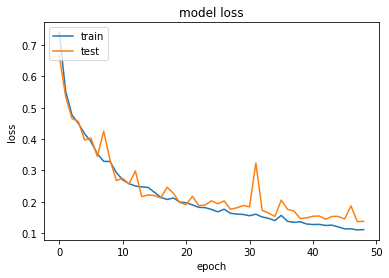

In [ ]:
import copy

INPUT_SIZE = 1
OUTPUT_SIZE = 3

# some training options
options['gpu_use'] = True
options['num_epochs'] = EPOCH_NO

# define the torch.device
device = torch.device('cuda') if options['gpu_use'] else torch.device('cpu')

# Define the Unet model
if MODEL_TYPE == "UNet":
  segmentation_model = UNet(in_channels=INPUT_SIZE, out_channels=OUTPUT_SIZE)


# define the optimizer
if options["optim"] == "sgd":
  optimizer = optim.SGD(segmentation_model.parameters(), lr=lrate, momentum=0.9, weight_decay=weightdecay)
elif options["optim"] == "adadelta":
  optimizer = optim.Adadelta(segmentation_model.parameters())
elif options["optim"] == "adam":
  optimizer = optim.Adam(segmentation_model.parameters(), lr=lrate, weight_decay=weightdecay) #weight_decay, lambda, L2 regularization
else:
  print("Please choose correct optimizer")

logger.info("Exp-Name:"+exp_name)

# send the model to the device
segmentation_model = segmentation_model.to(device)

# copy the parameters of the model
best_model_wts = copy.deepcopy(segmentation_model.state_dict())

training_loss_list = []
training_acc_list = []
val_loss_list = []
val_acc_list = []
best_loss = 1e+5

# training loop
early_count = 0
since = time.time()
training = True
epoch = 1
try:
    while training:

        # epoch specific metrics
        train_loss = 0

        train_accuracy = 0
        dice_endocard = 0
        dice_myo = 0
        dice_backgr = 0


        val_loss = 0

        val_accuracy = 0
        dice_endocard_val = 0
        dice_myo_val = 0
        dice_backgr_val = 0

        # -----------------------------
        # training samples
        # -----------------------------

        # set the model into train mode
        segmentation_model.train()
        for b_training, batch in enumerate(training_dataloader):
                # process batches: each batch is composed by training (x) and labels (y)
                # x = [32, 1, 144, 144]
                # y = [32, 1, 144, 144]

                x = batch[0].to(device)
                y = batch[1].to(device)

                # clear gradients
                optimizer.zero_grad()

                # infer the current batch
                pred = segmentation_model(x)
                pred_prob = pred

                # compute the loss.
                #Dice loss is (1 - dice coefficient)
                if options["loss_type"] == "diceloss":
                  #One hot encoded label
                  y_sq = y.squeeze(dim=1).long() # N, d2, d3
                  target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2
                  loss = dice_loss_all(pred, target)

                #use crossentropy
                elif options["loss_type"] == "crossentropy":

                  #log of softmax prediction (in range (1E-7, 1.0) to avoid log 0) which gives the value before softmax(e_xi/sum(e_xj))  activation b/se
                  # crossentropy includes softmax inside it
                  loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),
                                       y.squeeze(dim=1).long()) #

                else:
                      print("Please Choose the correct Loss type")
                      training = False
                      break

                train_loss += loss.item()

                # calculates the gradient wrt the loss
                loss.backward()
                #update the weights based on the computed gradient
                optimizer.step()

                if options["metrics"] == "dicecoeff":
                  # one hot encode
                  y_sq = y.squeeze(dim=1).long() # N, d2, d3
                  target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2
                  #Argmax
                  pred = pred.max(1, keepdim=True)[1]

                  dice_backgr += dice_coef_metric(pred_prob[:,0,:,:], target[:,0,:,:])
                  dice_myo += dice_coef_metric(pred_prob[:,1,:,:], target[:,1,:,:])
                  dice_endocard += dice_coef_metric(pred_prob[:,2,:,:], target[:,2,:,:])


        # -----------------------------
        # validation samples
        # -----------------------------

        # set the model into validation mode
        segmentation_model.eval()
        for b_validation, batch in enumerate(validation_dataloader):
                x = batch[0].to(device)
                y = batch[1].to(device)

                # infer the current batch,
                # don't compute the gradients, we don't need gradients during validation
                with torch.no_grad():
                    pred = segmentation_model(x)
                    pred_prob = pred


                    # Compute the loss
                    if options["loss_type"] == "diceloss":
                      #One hot encoded label
                      y_sq = y.squeeze(dim=1).long() # N, d2, d3
                      target = F.one_hot(y_sq, num_classes = OUTPUT_SIZE).permute(0,3,1,2).contiguous()  #N, C, d1, d2
                      loss = dice_loss_all(pred, target)
                    elif options["loss_type"] == "crossentropy":
                      loss = F.cross_entropy(torch.log(torch.clamp(pred, 1E-7, 1.0)),   #log of softmax prediction (in range 1E-7, 1.0)
                                          y.squeeze(dim=1).long()) #

                    else:
                      print("Please Choose the correct Loss type")
                      training = False
                      break


                    val_loss += loss.item()


                    if options["metrics"] == "dicecoeff":
                      y_sq = y.squeeze(dim=1).long() # N, d2, d3
                      target = F.one_hot(y_sq, num_classes = 3).permute(0,3,1,2).contiguous()  #N, C, d1, d2
                      # Argmax: returns (values, indices)
                      pred = pred.max(1, keepdim=True)[1]

                      dice_backgr_val += dice_coef_metric(pred_prob[:,0,:,:], target[:,0,:,:])
                      dice_myo_val += dice_coef_metric(pred_prob[:,1,:,:], target[:,1,:,:])
                      dice_endocard_val += dice_coef_metric(pred_prob[:,2,:,:], target[:,2,:,:])


        # compute mean metrics, the average of total batch dices
        train_loss /= (b_training + 1)
        train_accuracy /= (b_training + 1)
        dice_myo /= (b_training + 1)
        dice_endocard /= (b_training + 1)
        dice_backgr /= (b_training + 1)
        dice_avg = (dice_endocard + dice_myo + dice_backgr) / 3

        val_loss /= (b_validation + 1)
        val_accuracy /= (b_validation + 1)
        dice_endocard_val /= (b_validation + 1)
        dice_myo_val /= (b_validation + 1)
        dice_backgr_val /= (b_validation + 1)
        dice_avg_val = (dice_endocard_val + dice_myo_val + dice_backgr_val) / 3

        # Save the training and val loss for each batch

        training_acc_list.append(dice_avg)
        training_loss_list.append(train_loss)
        val_acc_list.append(dice_avg_val)
        val_loss_list.append(val_loss)

        if options["metrics"] == "dicecoeff":
          logger.info('Epoch {:d}/{:d} diceloss {:.4f} dice_endocard {:.4f} dice_myo {:.4f} dice_backgr {:.4f} val_diceloss {:.4f} val_dice_endocard {:.4f} val_dice_myo {:.4f} val_dice_backgr {:.4f} '.format(
              epoch,
              EPOCH_NO,
              train_loss,
              dice_endocard,
              dice_myo,
              dice_backgr,
              val_loss,
              dice_endocard_val,
              dice_myo_val,
              dice_backgr_val))

        # update epochs
        epoch += 1

        #Save weights if validation loss decreases
        if val_loss < best_loss:
          best_loss = val_loss
          early_count = 0
          logger.info("val loss decreased...saving model")

          #copy the weights of the best model and save it
          best_model_wts = copy.deepcopy(segmentation_model.state_dict())
          torch.save(segmentation_model.state_dict(),
                  os.path.join(options['models'], model_name +'.pt'))

        # if validation loss doesn't decrease
        elif val_loss > best_loss:
              early_count += 1

        if epoch >= options['num_epochs'] or early_count == earlystopping:
            training = False
            if early_count == earlystopping:
              print("Training stopped due to early stopping")

            time_elapsed = time.time() - since
            logger.info('Training complete in {:.0f}m {:.0f}s'.format(
                time_elapsed // 60, time_elapsed % 60))

            # load best saved model's weights
            segmentation_model.load_state_dict(best_model_wts) #
            plotMetrics(training_loss_list, val_loss_list)

except KeyboardInterrupt:
    pass


In [ ]:
batch[0].shape

torch.Size([14, 1, 144, 144])

# Inference

The Dice coefficient gives an overall information about the quality of the segmentation. The Dice index gives a measurement value
between 0 (no overlap) and 1 (full overlap).

Hausdorff distance is the greatest of all distances from a
point in one set to the closest point in the other set. It measures the local maximum distance between the two surfaces. The Hausdorff distance highlights the outliers.

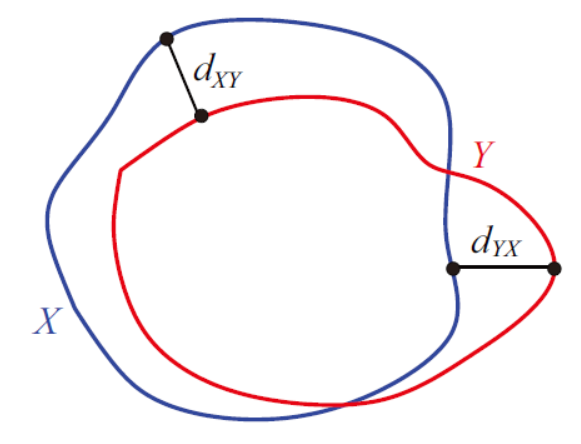

## Validation

Prediction on the validation dataset

In [ ]:
from scipy.spatial.distance import directed_hausdorff

metrics = np.zeros((len(validation_data), 4))

validation_dataloader_one = DataLoader(validation_dataset,
                                 batch_size=1,
                                 shuffle=False)


# set the model into validation mode
segmentation_model.eval()
for ii, batch in enumerate(validation_dataloader_one):
  x = batch[0].to(device)
  y = batch[1].to(device)
  # infer the current batch
  with torch.no_grad():
      pred = segmentation_model(x)
      pred_prob = pred

      y_sq = y.squeeze(dim=1).long() # N, d2, d3
      target = F.one_hot(y_sq, num_classes = 3).permute(0,3,1,2).contiguous()  #N, C, d1, d2

      # Argmax: returns (values, indices)
      pred = pred.max(1, keepdim=True)[1]

      # compute the dice coefficient of myocardium and endocardium (LV)
      dice_myo_test = dice_coef_metric(pred_prob[:,1,:,:], target[:,1,:,:])
      dice_endocard_test = dice_coef_metric(pred_prob[:,2,:,:], target[:,2,:,:])

      # compute the Hausdorff distance (HD) of myocardium and endocardium (LV)
      hd_myo_test = directed_hausdorff(pred_prob[0,1,:,:].cpu().numpy(), target[0,1,:,:].cpu().numpy())[0]
      hd_endocard_test = directed_hausdorff(pred_prob[0,2,:,:].cpu().numpy(), target[0,2,:,:].cpu().numpy())[0]

      metrics[ii, 0], metrics[ii, 1] = dice_endocard_test, dice_myo_test
      metrics[ii, 2], metrics[ii, 3] = hd_endocard_test, hd_myo_test

      print(" Endo: {:.4f} Myo: {:.4f} ".format(metrics[ii,0], metrics[ii,1]))
      #Display the result of a batch
      fig=plt.figure(figsize=(8, 8))
      fig.add_subplot(1, 3, 1)
      plt.imshow(batch[0][0,0,:,:],cmap='gray')
      plt.title("Image")
      fig.add_subplot(1,3, 2)
      pred_cpu=pred.cpu().numpy()
      plt.imshow(pred_cpu[0,0,:,:])
      plt.title("Predicted")
      fig.add_subplot(1, 3, 3)
      plt.imshow(batch[1][0,0,:,:])
      plt.title("GT")
      plt.show()


# we use PANDAS to describe data :)
import pandas as pd

#show the statistics in terms of Dice and HD
df_evaluation = pd.DataFrame(metrics, columns=['Endocardium', 'Myocardium',  'Hausdorff Endo','Hausdorff Myo'])
df_evaluation.describe().T


## Test Inference

Prediction on the test dataset

In [ ]:
from scipy.spatial.distance import directed_hausdorff

metrics = np.zeros((len(test_data), 4))


test_dataloader_one = DataLoader(test_dataset,
                                 batch_size=1,
                                 shuffle=False)


# set the model into validation mode
segmentation_model.eval()
for ii, batch in enumerate(test_dataloader_one):
  x = batch[0].to(device)
  y = batch[1].to(device)
  # infer the current batch
  with torch.no_grad():
      pred = segmentation_model(x)
      pred_prob = pred

      y_sq = y.squeeze(dim=1).long() # N, d2, d3
      target = F.one_hot(y_sq, num_classes = 3).permute(0,3,1,2).contiguous()  #N, C, d1, d2
      # Argmax: returns (values, indices)
      pred = pred.max(1, keepdim=True)[1]

      dice_myo_test = dice_coef_metric(pred_prob[:,1,:,:], target[:,1,:,:])
      dice_endocard_test = dice_coef_metric(pred_prob[:,2,:,:], target[:,2,:,:])

      hd_myo_test = directed_hausdorff(pred_prob[0, 1,:,:].cpu().numpy(), target[0,1,:,:].cpu().numpy())[0]
      hd_endocard_test = directed_hausdorff(pred_prob[0, 2,:,:].cpu().numpy(), target[0,2,:,:].cpu().numpy())[0]

      metrics[ii, 0], metrics[ii, 1] = dice_endocard_test, dice_myo_test
      metrics[ii, 2], metrics[ii, 3] = hd_endocard_test, hd_myo_test

      print(" Endo:  {:.4f} Myo: {:.4f} ".format(metrics[ii,0], metrics[ii,1]))
      #Display the result of a batch
      fig=plt.figure(figsize=(8, 8))
      fig.add_subplot(1, 3, 1)
      plt.imshow(batch[0][0,0,:,:],cmap='gray')
      plt.title("Image")
      fig.add_subplot(1,3, 2)
      pred_cpu=pred.cpu().numpy()
      plt.imshow(pred_cpu[0,0,:,:])
      plt.title("Predicted")
      fig.add_subplot(1, 3, 3)
      plt.imshow(batch[1][0,0,:,:])
      plt.title("GT")
      plt.show()


# we use PANDAS to describe data :)
import pandas as pd

df_evaluation = pd.DataFrame(metrics, columns=['Endocardium', 'Myocardium',  'Hausdorff Endo','Hausdorff Myo'])
df_evaluation.describe().T



# Final Exercises



<ol>
    <hr>
        <li>Reset the model by running the code under <code>simplified UNET</code> section , then modify the hyperparameters including the loss type, optimizer type etc and retrain the model. Can you make it converge faster than the default values?  </li><hr>
    <li>Modify the architecture under <code>simplified UNET</code> section and note the effects on the training speed and final dice coefficient
        <ol>
            <li> Easy: Change the number of kernels of the convolutions, the size of the convolution kernel (check also the padding)</li>
            <li> Medium: Increase the depth of the UNET by adding more pooling/upsampling layers. Check also the size of feature map at the bottleneck of UNET.</li>
            <li> Hard: Add <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/batchnorm.html#BatchNorm1d">batchnorm</a>, and/or <a href="https://pytorch.org/docs/stable/_modules/torch/nn/modules/dropout#Dropout">dropout</a> layers.</li>
        </ol>
    </li><hr>
    <li>Replace the <code>max-pooling</code> layer by a  <code>Conv</code> layer with kernel size 2 and stride 2. Furthermore, <b>concatenate</b> the feature maps that goes from the encoder to the decoder instead of <b>adding</b> them. Did you notice any change on the performance?</li><hr>
    <li><b>Final challenge:</b> In order to improve the segmentation results further, use data augmentation. You can try horizontal/vertical flip, random rotation, affine transform etc... . </li>
</ol>

